# LSTM tests with S&P's 500

Exercise proposed and conducted by David Griñán and Pablo Talavante, AI Saturdays Madrid.

We are going to use Kaggle's [S&P 500 stock data](https://www.kaggle.com/camnugent/sandp500) to study the use of LSTMs for time-series analysis.

Sections:

- [Data Analysis](#Data-Analysis)
- [Predict a stock](#Predict-a-stock)
- [Use _all_ stocks to predict `AAPL`](#Use-all-stocks-to-predict-AAPL)
- [Use PyTorch instead of Keras](#Use-PyTorch-instead-of-Keras)

## Data Analysis

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai import *
from fastai.vision import *

You need to download the dataset from Kaggle and adjust your path below.

In [209]:
path = Path('./data/sandp500')
path.ls()

[PosixPath('data/sandp500/individual_stocks_5yr.zip'),
 PosixPath('data/sandp500/merge.sh'),
 PosixPath('data/sandp500/getSandP.py'),
 PosixPath('data/sandp500/all_stocks_5yr.csv')]

In [210]:
stocks = pd.read_csv(path / 'all_stocks_5yr.csv')

In [211]:
stocks.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')

In [212]:
stocks.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [213]:
names = stocks['Name'].unique()
names

array(['AAL', 'AAPL', 'AAP', 'ABBV', ..., 'YUM', 'ZBH', 'ZION', 'ZTS'], dtype=object)

In [214]:
len(stocks[stocks['Name'] == 'AAPL'])

1259

In [215]:
len(stocks[stocks['Name'] == 'AMZN'])

1259

Even though most of the stocks have the same amount of data (1259 samples, corresponding to 5 years of trading activity), some of them contain as few as 44 samples. We will remove all the stocks that have less than 1259 entries.

In [216]:
counts = {x:len(stocks[stocks['Name'] == x]) for x in names}
print(counts['AMZN'])
print(counts['APTV'])

1259
44


In [217]:
with_insufficient_data = [x for x in counts.keys() if counts[x] < 1259]
with_insufficient_data

['ALLE',
 'APTV',
 'BHF',
 'BHGE',
 'BMY',
 'CFG',
 'COTY',
 'CSRA',
 'DHR',
 'DWDP',
 'DXC',
 'ES',
 'EVHC',
 'FOXA',
 'FOX',
 'FTV',
 'GOOG',
 'HLT',
 'HPE',
 'HPQ',
 'ICE',
 'INFO',
 'IQV',
 'KHC',
 'NAVI',
 'NWSA',
 'NWS',
 'ORCL',
 'O',
 'PYPL',
 'QRVO',
 'SYF',
 'UA',
 'WLTW',
 'WRK']

### Drop the stocks with less than 1259 samples

In [218]:
for s in with_insufficient_data:
    stocks = stocks.drop(stocks[stocks['Name'] == s].index)

Update `names` and `counts`.

In [219]:
names = stocks['Name'].unique()
counts = {x:len(stocks[stocks['Name'] == x]) for x in names}
[x for x in counts.keys() if counts[x] < 1259]

[]

## Predict a stock

We are going to use time-series data for a given stock to predict time-series values for the same stock.

In [220]:
company = 'AAPL'
apple_close_series_df = stocks[stocks['Name'] == company]['close']
apple_close_series_df

1259     67.8542
1260     68.5614
1261     66.8428
1262     66.7156
1263     66.6556
1264     65.7371
1265     65.7128
1266     64.1214
1267     63.7228
1268     64.4014
1269     63.2571
1270     64.1385
1271     63.5099
1272     63.0571
1273     61.4957
1274     60.0071
1275     61.5919
1276     60.8088
1277     61.5117
1278     61.6742
1279     62.5528
1280     61.2042
1281     61.1928
1282     61.7857
1283     63.3799
1284     65.1028
1285     64.9271
1286     64.5828
1287     64.6756
1288     65.9871
          ...   
2488    170.5700
2489    170.6000
2490    171.0800
2491    169.2300
2492    172.2600
2493    172.2300
2494    173.0300
2495    175.0000
2496    174.3500
2497    174.3300
2498    174.2900
2499    175.2800
2500    177.0900
2501    176.1900
2502    179.1000
2503    179.2600
2504    178.4600
2505    177.0000
2506    177.0400
2507    174.2200
2508    171.1100
2509    171.5100
2510    167.9600
2511    166.9700
2512    167.4300
2513    167.7800
2514    160.5000
2515    156.49

In [221]:
# drop the index
apple_close_series = apple_close_series_df.values
apple_close_series

array([ 67.8542,  68.5614,  66.8428,  66.7156, ..., 160.5   , 156.49  , 163.03  , 159.54  ])

The `apple_close_series` array contains all stock values at market close for the selected stock. We are going to build a matrix with 21 columns. The first 20 columns will be our `X`: stock values for 20 consecutive days, while the 21st column will be our `Y`: the market close value the following day after the series. We will have as many rows as complete 20-day series exist in the source data. The window length (20) is configurable.

In [222]:
window_len = 20
xy_data = []

for i, v in enumerate(apple_close_series):
    row = apple_close_series[i:i+window_len+1]
    if len(row) < window_len + 1:
        break
    if len(xy_data) == 0:
        # First row - initialize our data
        xy_data = row
    else:
        # Stack the new row below the existing ones
        xy_data = np.vstack([xy_data, row])

xy_data

array([[ 67.8542,  68.5614,  66.8428,  66.7156, ...,  60.8088,  61.5117,  61.6742,  62.5528],
       [ 68.5614,  66.8428,  66.7156,  66.6556, ...,  61.5117,  61.6742,  62.5528,  61.2042],
       [ 66.8428,  66.7156,  66.6556,  65.7371, ...,  61.6742,  62.5528,  61.2042,  61.1928],
       [ 66.7156,  66.6556,  65.7371,  65.7128, ...,  62.5528,  61.2042,  61.1928,  61.7857],
       ...,
       [173.03  , 175.    , 174.35  , 174.33  , ..., 166.97  , 167.43  , 167.78  , 160.5   ],
       [175.    , 174.35  , 174.33  , 174.29  , ..., 167.43  , 167.78  , 160.5   , 156.49  ],
       [174.35  , 174.33  , 174.29  , 175.28  , ..., 167.78  , 160.5   , 156.49  , 163.03  ],
       [174.33  , 174.29  , 175.28  , 177.09  , ..., 160.5   , 156.49  , 163.03  , 159.54  ]])

In [223]:
xy_data.shape

(1239, 21)

### Normalize everything

For numeric stability reasons, scale values so they all lie in the 0..1 range. `0` represents the minimum value of the stock in the given period, while `1` represents the maximum. Our model will be trained using these new normalized values. The trained model will not work for future values out of the range we used for normalization. 

In [224]:
xy_max = xy_data.max()
xy_min = xy_data.min()

xy_data = (xy_data - xy_min) / (xy_max - xy_min)
xy_data

array([[0.09771 , 0.103438, 0.089519, 0.088489, ..., 0.040649, 0.046342, 0.047658, 0.054774],
       [0.103438, 0.089519, 0.088489, 0.088003, ..., 0.046342, 0.047658, 0.054774, 0.043851],
       [0.089519, 0.088489, 0.088003, 0.080564, ..., 0.047658, 0.054774, 0.043851, 0.043759],
       [0.088489, 0.088003, 0.080564, 0.080367, ..., 0.054774, 0.043851, 0.043759, 0.048561],
       ...,
       [0.949542, 0.965498, 0.960233, 0.960071, ..., 0.900462, 0.904187, 0.907022, 0.84806 ],
       [0.965498, 0.960233, 0.960071, 0.959747, ..., 0.904187, 0.907022, 0.84806 , 0.815583],
       [0.960233, 0.960071, 0.959747, 0.967765, ..., 0.907022, 0.84806 , 0.815583, 0.868551],
       [0.960071, 0.959747, 0.967765, 0.982425, ..., 0.84806 , 0.815583, 0.868551, 0.840285]])

Create function to go back to the actual values.

In [225]:
def unnormalize(v):
    return xy_min + (xy_max - xy_min) * v

unnormalize(xy_data[0, -1])

62.5528

### Create train / validation split

In [226]:
train_data = xy_data[0:round(len(xy_data)*0.8), :]
val_data = xy_data[round(len(xy_data)*0.8)+1:, :]
print(train_data.shape, val_data.shape)

(991, 21) (247, 21)


In [227]:
X_train = train_data[:, :-1]
Y_train = train_data[:, -1]
print(X_train.shape, Y_train.shape)

(991, 20) (991,)


### LSTM by [pablotalavante](https://github.com/pablotalavante/ai6-madrid-demos/blob/master/session_4/LSTM%20sesion%204.ipynb)

In [228]:
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [229]:
def create_model():
    model = Sequential()
    model.add(LSTM(20,
              input_shape=(20, 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    return model


In [230]:
X = np.expand_dims(X_train, -1)

La entrada del modelo debe tener la forma [batch_size, time_steps, features]
En nuestro caso, si solo tenemos una feature, necesitamos exandir la dimensión de nuestra matriz 2-D para que entre en la red neuronal y se quede con al forma [batch_size, time_steps, 1], ya que únicamente tenemos una feature


In [231]:
model = create_model()

In [232]:
for i in range(10):
    model.fit(X, Y_train, batch_size=64, epochs=5,
                       verbose=1, shuffle=True)

Epoch 1/5
991/991 [==============================] - 2s 2ms/step - loss: 0.0830
Epoch 2/5
991/991 [==============================] - 1s 630us/step - loss: 0.0100
Epoch 3/5
991/991 [==============================] - 1s 643us/step - loss: 0.0060
Epoch 4/5
991/991 [==============================] - 1s 661us/step - loss: 0.0037
Epoch 5/5
991/991 [==============================] - 1s 660us/step - loss: 0.0025
Epoch 1/5
991/991 [==============================] - 1s 642us/step - loss: 0.0017
Epoch 2/5
991/991 [==============================] - 1s 640us/step - loss: 0.0012
Epoch 3/5
991/991 [==============================] - 1s 627us/step - loss: 9.2116e-04
Epoch 4/5
991/991 [==============================] - 1s 633us/step - loss: 8.0555e-04
Epoch 5/5
991/991 [==============================] - 1s 629us/step - loss: 7.6600e-04
Epoch 1/5
991/991 [==============================] - 1s 642us/step - loss: 7.6230e-04
Epoch 2/5
991/991 [==============================] - 1s 648us/step - loss: 7.4766e-0

### Verify results

In [233]:
X_val = val_data[:, :-1]
Y_val = val_data[:, -1]

In [234]:
X_expanded = np.expand_dims(X_val, -1)

In [235]:
Y_pred = model.predict(X_expanded)

In [236]:
len(Y_val)

247

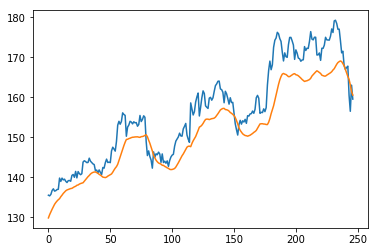

In [237]:
# Plot
plt.plot(unnormalize(Y_val))
plt.plot(unnormalize(Y_pred))

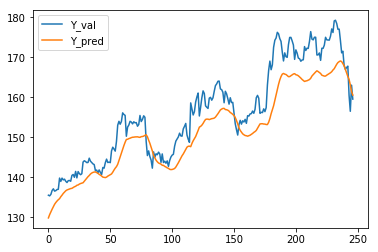

In [238]:
# Plot with legends
fig, ax = plt.subplots()
ax.plot(unnormalize(Y_val), label='Y_val')
ax.plot(unnormalize(Y_pred), label='Y_pred')
ax.legend()

**To Do** Why is the predicted curve below the actual one?

## Use _all_ stocks to predict `AAPL`

In [239]:
names = stocks['Name'].unique()

In [240]:
len(names)

470

Build a tensor with all stocks. Normalize stocks individually. Keep `Y` being `AAPL`.

In [241]:
D = []
window_size = 20

y = []
for n in names:
    X = []
    asset = stocks[stocks['Name'] == n]
    for t in range(asset.shape[0] - window_size):
        instance = asset['close'][t:t+window_size+1].values
        if n == 'AAPL':
            y.append(instance[-1])
        X.append(instance[:-1])
    X_NP = np.asarray(X)
    X_NP = (X_NP - X_NP.min()) / (X_NP.max() - X_NP.min())
    D.append(X_NP)

In [242]:
# Normalize Y
y = np.asarray(y)
y = (y - y.min()) / (y.max() - y.min())

In [243]:
D = np.stack(D, axis=-1)
D.shape

(1239, 20, 470)

In [244]:
X_train = D[:1000]
y_train = y[:1000]

X_test = D[1000:]
y_test = y[1000:]

In [249]:
def create_model():
    model = Sequential()
    model.add(LSTM(120,
              input_shape=(20, len(names))))
    model.add(Dense(20))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [250]:
model = create_model()

Provide validation data to `fit()` so we get feedback about the validation loss.

In [251]:
model.fit(X_train, y_train, batch_size=64, epochs=25,
                       verbose=1, shuffle=True, validation_data=(X_test, y_test))

Train on 1000 samples, validate on 239 samples
Epoch 1/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6160 - val_loss: 0.0520
Epoch 2/25
1000/1000 [==============================] - 1s 831us/step - loss: 0.0384 - val_loss: 0.0124
Epoch 3/25
1000/1000 [==============================] - 1s 833us/step - loss: 0.0122 - val_loss: 0.0932
Epoch 4/25
1000/1000 [==============================] - 1s 847us/step - loss: 0.0052 - val_loss: 0.1070
Epoch 5/25
1000/1000 [==============================] - 1s 833us/step - loss: 0.0031 - val_loss: 0.0831
Epoch 6/25
1000/1000 [==============================] - 1s 839us/step - loss: 0.0024 - val_loss: 0.0746
Epoch 7/25
1000/1000 [==============================] - 1s 831us/step - loss: 0.0020 - val_loss: 0.0608
Epoch 8/25
1000/1000 [==============================] - 1s 825us/step - loss: 0.0018 - val_loss: 0.0552
Epoch 9/25
1000/1000 [==============================] - 1s 839us/step - loss: 0.0017 - val_loss: 0.0503
Epoch 10/25
1000/10

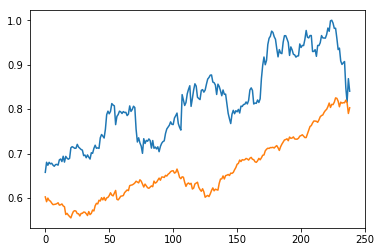

In [253]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

**To Do** Note that each stock has been normalized independently. Does that have an impact on the prediction?

## Use _some_ stocks to predict `AAPL`

We will now use a few technology stocks to see how they perform with respect to the previous case.

In [264]:
some_tech_symbols = ['AAPL', 'AMZN', 'FB', 'MSFT', 'GOOGL', 'NFLX', 'TWTR', 'AMD']
tech_symbols = [t for t in some_tech_symbols if t in names]
tech_symbols

['AAPL', 'AMZN', 'FB', 'MSFT', 'GOOGL', 'NFLX', 'AMD']

In [308]:
def tensor_from_symbols(symbols):
    D = []
    window_size = 20

    y = []
    for n in symbols:
        X = []
        asset = stocks[stocks['Name'] == n]
        for t in range(asset.shape[0] - window_size):
            instance = asset['close'][t:t+window_size+1].values
            if n == 'AAPL':
                y.append(instance[-1])
            X.append(instance[:-1])
            
        X_NP = np.asarray(X)
        X_NP = (X_NP - X_NP.min()) / (X_NP.max() - X_NP.min())
        D.append(X_NP)
        
    y = np.asarray(y)
    y = (y - y.min()) / (y.max() - y.min())
    D = np.stack(D, axis=-1)
    
    return D, y

In [309]:
D, y = tensor_from_symbols(tech_symbols)

In [310]:
D.shape

(1239, 20, 7)

In [311]:
X_train = D[:1000]
y_train = y[:1000]

X_test = D[1000:]
y_test = y[1000:]

In [312]:
def create_model(n_symbols):
    model = Sequential()
    model.add(LSTM(120,
              input_shape=(20, n_symbols)))
    model.add(Dense(20))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [313]:
model = create_model(len(tech_symbols))

Provide validation data to `fit()` so we get feedback about the validation loss.

In [314]:
model.fit(X_train, y_train, batch_size=64, epochs=25,
                       verbose=1, shuffle=True, validation_data=(X_test, y_test))

Train on 1000 samples, validate on 239 samples
Epoch 1/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0273 - val_loss: 0.0307
Epoch 2/25
1000/1000 [==============================] - 1s 750us/step - loss: 0.0041 - val_loss: 0.0317
Epoch 3/25
1000/1000 [==============================] - 1s 748us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/25
1000/1000 [==============================] - 1s 739us/step - loss: 7.0290e-04 - val_loss: 0.0014
Epoch 5/25
1000/1000 [==============================] - 1s 746us/step - loss: 5.1435e-04 - val_loss: 8.7618e-04
Epoch 6/25
1000/1000 [==============================] - 1s 742us/step - loss: 4.8443e-04 - val_loss: 8.8479e-04
Epoch 7/25
1000/1000 [==============================] - 1s 749us/step - loss: 4.7141e-04 - val_loss: 7.5170e-04
Epoch 8/25
1000/1000 [==============================] - 1s 701us/step - loss: 4.4368e-04 - val_loss: 0.0018
Epoch 9/25
1000/1000 [==============================] - 1s 743us/step - loss: 4.5988e-04 - 

In [315]:
y_tech_pred = model.predict(X_test)

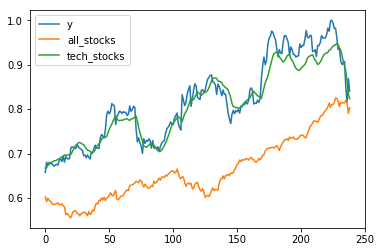

In [316]:
fig, ax = plt.subplots()
ax.plot(y_test, label='y')
ax.plot(y_pred, label='all_stocks')
ax.plot(y_tech_pred, label='tech_stocks')
ax.legend()

The fact that `AAPL` is included probably dominates the new prediction. Let's exclude `AAPL` and retrain.

In [319]:
tech_sans_apple = [t for t in tech_symbols if t != 'AAPL']

In [321]:
D = []
window_size = 20

for n in tech_sans_apple:
    X = []
    asset = stocks[stocks['Name'] == n]
    for t in range(asset.shape[0] - window_size):
        instance = asset['close'][t:t+window_size+1].values
        X.append(instance[:-1])

    X_NP = np.asarray(X)
    X_NP = (X_NP - X_NP.min()) / (X_NP.max() - X_NP.min())
    D.append(X_NP)

D = np.stack(D, axis=-1)

In [322]:
D.shape

(1239, 20, 6)

In [326]:
# We still have y from a previous section
y.shape

(1239,)

In [327]:
X_train = D[:1000]
y_train = y[:1000]

X_test = D[1000:]
y_test = y[1000:]

In [328]:
def create_model(n_symbols):
    model = Sequential()
    model.add(LSTM(120,
              input_shape=(20, n_symbols)))
    model.add(Dense(20))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [329]:
model = create_model(len(tech_sans_apple))

Provide validation data to `fit()` so we get feedback about the validation loss.

In [330]:
model.fit(X_train, y_train, batch_size=64, epochs=25,
                       verbose=1, shuffle=True, validation_data=(X_test, y_test))

Train on 1000 samples, validate on 239 samples
Epoch 1/25
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0263 - val_loss: 0.0094
Epoch 2/25
1000/1000 [==============================] - 1s 727us/step - loss: 0.0121 - val_loss: 0.0621
Epoch 3/25
1000/1000 [==============================] - 1s 752us/step - loss: 0.0075 - val_loss: 0.0518
Epoch 4/25
1000/1000 [==============================] - 1s 756us/step - loss: 0.0043 - val_loss: 0.0132
Epoch 5/25
1000/1000 [==============================] - 1s 723us/step - loss: 0.0039 - val_loss: 0.0209
Epoch 6/25
1000/1000 [==============================] - 1s 755us/step - loss: 0.0036 - val_loss: 0.0252
Epoch 7/25
1000/1000 [==============================] - 1s 711us/step - loss: 0.0035 - val_loss: 0.0307
Epoch 8/25
1000/1000 [==============================] - 1s 727us/step - loss: 0.0035 - val_loss: 0.0295
Epoch 9/25
1000/1000 [==============================] - 1s 772us/step - loss: 0.0035 - val_loss: 0.0276
Epoch 10/25
1000/10

In [331]:
y_no_aapl_pred = model.predict(X_test)

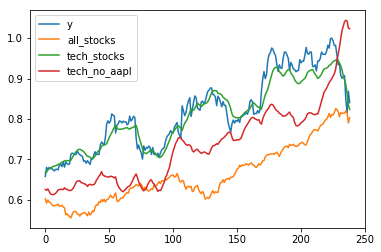

In [333]:
fig, ax = plt.subplots()
ax.plot(y_test, label='y')
ax.plot(y_pred, label='all_stocks')
ax.plot(y_tech_pred, label='tech_stocks')
ax.plot(y_no_aapl_pred, label='tech_no_aapl')
ax.legend()

## Use PyTorch instead of Keras

**To Do**